# Lab 3: FIR Filter 
In this notebook you will test your designed FIR filter on the PYNQ-Z2 board. 

You will need to plug headphones into your PYNQ board to hear the audio output.

# 1: Load the Overlay

In [1]:
import numpy as np
from pynq import allocate
from pynq import Overlay

ol = Overlay("/home/xilinx/jupyter_notebooks/base_filter.bit")

# 2: Play the Audio File

In [2]:
dma = ol.axi_dma

In [3]:
input_buffer = allocate(shape=(64,), dtype=np.uint32)
output_buffer = allocate(shape=(64,), dtype=np.uint32)

In [4]:
for i in range(64):
   input_buffer[i] = i+10

In [5]:
dma.sendchannel.transfer(input_buffer)
dma.sendchannel.wait()

In [6]:
dma.recvchannel.transfer(output_buffer)
dma.recvchannel.wait()

In [7]:
print("Arrays are equal: {}".format(np.array_equal(input_buffer, output_buffer)))

Arrays are equal: False


In [8]:
pynqAudio = ol.audio_codec_ctrl_0 #might use the default app, so audio items might not work here. 

#pynqAudio.set_volume(15)

In [9]:
pynqAudio.load("/home/xilinx/jupyter_notebooks/base/audio/recording_0.wav")
#make a local copy of the buffer to process and manipulate
pynqAudio_buffer = pynqAudio.buffer.copy()

In [10]:
pynqAudio.configure()

In [11]:
pynqAudio.play()

In [12]:
samplelen = len(pynqAudio.buffer)
print(samplelen)

480000


The audio signal is 2 channels, concatenated. For filtering, we need to serialise the channels - this requires reshaping the input and manipulating the outputs to achieve the required order. In this specific case, we are reshaping the input buffer, transposing and then concatenating to create the required serialised format (Alternatively, the filter could be designed for multi-channel operation - a bit more complex to manage that from Pynq). 

# 3: Process the Audio

### Get info from the audio signal
Use the wave library to obtain the frames, number of channels, sampling rate and width of the audio.

In [13]:
%matplotlib inline
import wave
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fftpack import fft

wav_path = "/home/xilinx/jupyter_notebooks/base/audio/recording_0.wav"
with wave.open(wav_path, 'r') as wav_file:
    raw_frames = wav_file.readframes(-1)
    num_frames = wav_file.getnframes()
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()

### Decode the interleaved channel data into seperate channels

In [14]:
inbuffer = allocate(shape=(samplelen,), dtype=np.int32)
outbuffer = allocate(shape=(samplelen,), dtype=np.int32)


temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
bytes_raw = np.frombuffer(pynqAudio_buffer, dtype=np.uint8)

#Decode raw interleaved channel data into each channel with 4 bytes per channel- note that the upper bytes would be '0' and not properly sign extended
temp_buffer[:, :, :] = bytes_raw.reshape(-1, num_channels, 4) 
temp_buffer[:, :, sample_width:] = (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255 #Sign extend the buffer
frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1]) #Compose it back to int32 format (signed), little endian format
inbuffee = np.concatenate(frames.transpose(),0) #Concatenate the two channels without interleaving
inbuffer[:] = inbuffee[:]


### Check the formats are correctly aligned and sign-extended

In [15]:
for i in range(10):
    print(pynqAudio_buffer[i], inbuffer[i], frames[i], temp_buffer[i])
    

16759079 -18137 [-18137 -17228] [[ 39 185 255 255]
 [180 188 255 255]]
16759988 -16288 [-16288 -17228] [[ 96 192 255 255]
 [180 188 255 255]]
16760928 -18820 [-18820 -15814] [[124 182 255 255]
 [ 58 194 255 255]]
16759988 -17952 [-17952 -16718] [[224 185 255 255]
 [178 190 255 255]]
16758396 -15108 [-15108 -14742] [[252 196 255 255]
 [106 198 255 255]]
16761402 -11888 [-11888 -11436] [[144 209 255 255]
 [ 84 211 255 255]]
16759264 -16479 [-16479 -14577] [[161 191 255 255]
 [ 15 199 255 255]]
16760498 -17111 [-17111 -16331] [[ 41 189 255 255]
 [ 53 192 255 255]]
16762108 -21349 [-21349 -19321] [[155 172 255 255]
 [135 180 255 255]]
16762474 -31152 [-31152 -24503] [[ 80 134 255 255]
 [ 73 160 255 255]]


# 4. Implement FIR Filter

In [16]:
import time
st = time.time()
dma.sendchannel.transfer(inbuffer)
dma.recvchannel.transfer(outbuffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
et = time.time()

### Determine the hardware execution time

In [17]:
hw_exec_time = et - st
print("Hardware Execution time is: ",hw_exec_time)

Hardware Execution time is:  0.5241281986236572


### Remap to 2-channel audio format

In [18]:
len(outbuffer)

480000

The received buffer is in concatenated format and hence need to be remapped to the two channel audio format. Hence, the reorganisation in the reverse order - split, transpose and concatenate. 

In [19]:
outbuff_ser = np.split(outbuffer,2)
outbuff_trans = np.transpose(outbuff_ser)
outbuff_fin = np.concatenate(outbuff_trans)


### Play the filter output

In [20]:
pynqAudio.buffer = outbuff_fin.copy()
pynqAudio.play()

## 5: Plot the Audio

Now we can plot the two to see how they function. Recall that we had read the wave file using the wave library and ''raw_frames'' contains the raw data from the wavefile; We do the same processing as before to ensure the waveform is sign-extended and deinterleaved into separate channels.

### Decode interleaved channel data into each channel

In [21]:
temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8)
temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, 
                                                    sample_width)
temp_buffer[:, :, sample_width:] = \
    (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255

frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])
print(np.shape(temp_buffer))

(240000, 2, 4)


### Plot the original audio from the 2 channels

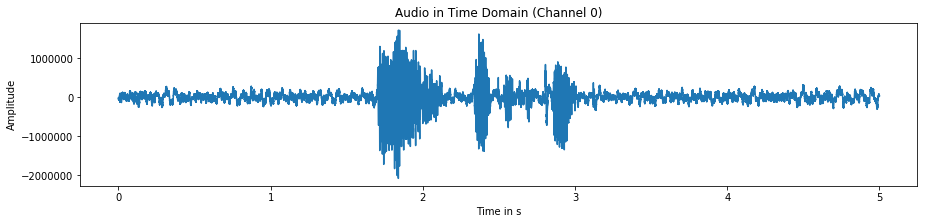

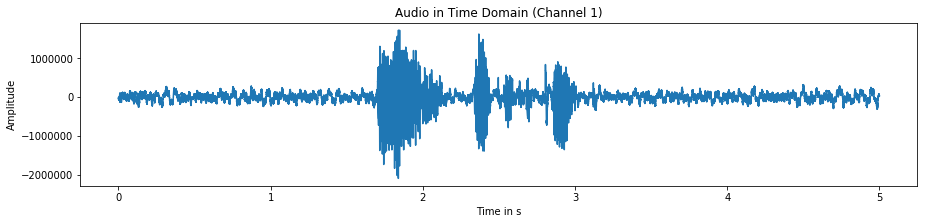

In [22]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
    plt.plot(time_axis, frames[:, channel_index])
    plt.show()

### Compare Filtered Signal with Original Audio

Now let us compare against the hardware output

In [23]:
temp_out = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
raw_out = np.frombuffer(outbuff_fin, dtype=np.uint8)
temp_out[:, :, :] = raw_out.reshape(-1, num_channels, 4)
frames_out = temp_out.view('<i4').reshape(temp_out.shape[:-1])

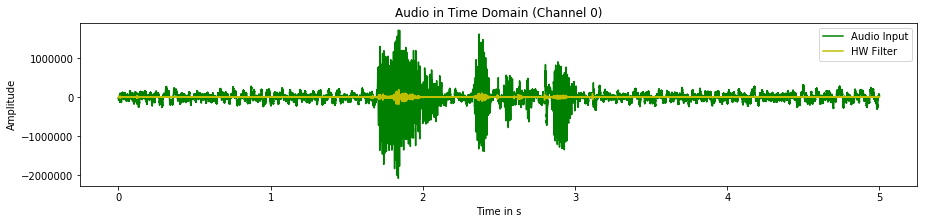

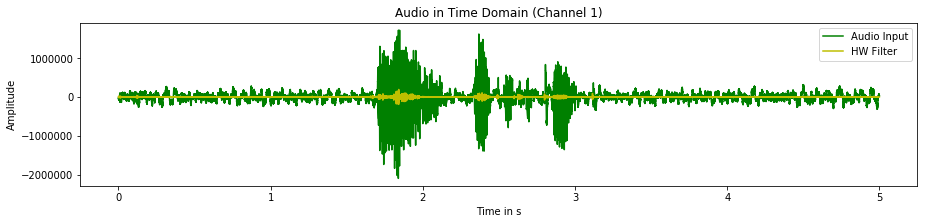

In [24]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
    plt.plot(time_axis, frames[:,channel_index], 'g-', label="Audio Input")
    plt.plot(time_axis, frames_out[:, channel_index], 'y-', label="HW Filter")
    plt.legend()
    plt.show()

# 6: Compare to Software Execution of Filter

In [27]:
from scipy.signal import lfilter
coeffs = [0.072143555,
-0.058349609,
-0.037109375,
-0.022094727,
-0.01159668,
-0.004272461,
0.000732422,
0.00402832,
0.006103516,
0.007324219,
0.00793457,
0.008178711,
0.008056641,
0.00769043,
0.007324219,
0.006713867,
0.006103516,
0.005493164,
0.004760742,
0.004150391,
0.003540039,
0.002807617,
0.002197266,
0.001586914,
0.000976563,
0.000366211,
-0.000244141,
-0.000854492,
-0.001342773,
-0.001831055,
-0.002319336,
-0.002807617,
-0.003173828,
-0.003540039,
-0.00390625,
-0.004150391,
-0.004394531,
-0.004638672,
-0.004760742,
-0.004760742,
-0.004882813,
-0.004760742,
-0.004760742,
-0.004638672,
-0.004394531,
-0.004150391,
-0.00378418,
-0.003417969,
-0.002929688,
-0.002441406,
-0.001953125,
-0.001342773,
-0.000854492,
-0.00012207,
0.000488281,
0.001220703,
0.001831055,
0.002563477,
0.003295898,
0.00402832,
0.004638672,
0.005249023,
0.005859375,
0.006347656,
0.006835938,
0.007202148,
0.007568359,
0.0078125,
0.00793457,
0.008056641,
0.00793457,
0.0078125,
0.007446289,
0.007080078,
0.006591797,
0.005981445,
0.005126953,
0.004272461,
0.003295898,
0.002075195,
0.000854492,
-0.000488281,
-0.001953125,
-0.003417969,
-0.005126953,
-0.006835938,
-0.008544922,
-0.010375977,
-0.012207031,
-0.014038086,
-0.015991211,
-0.017944336,
-0.019775391,
-0.021728516,
-0.02355957,
-0.025268555,
-0.026977539,
-0.028564453,
-0.030029297,
-0.031494141,
-0.032836914,
-0.034057617,
-0.03503418,
-0.035888672,
-0.036743164,
-0.037231445,
-0.037597656,
-0.037963867,
1,
-0.037963867,
-0.037597656,
-0.037231445,
-0.036743164,
-0.035888672,
-0.03503418,
-0.034057617,
-0.032836914,
-0.031494141,
-0.030029297,
-0.028564453,
-0.026977539,
-0.025268555,
-0.02355957,
-0.021728516,
-0.019775391,
-0.017944336,
-0.015991211,
-0.014038086,
-0.012207031,
-0.010375977,
-0.008544922,
-0.006835938,
-0.005126953,
-0.003417969,
-0.001953125,
-0.000488281,
0.000854492,
0.002075195,
0.003295898,
0.004272461,
0.005126953,
0.005981445,
0.006591797,
0.007080078,
0.007446289,
0.0078125,
0.00793457,
0.008056641,
0.00793457,
0.0078125,
0.007568359,
0.007202148,
0.006835938,
0.006347656,
0.005859375,
0.005249023,
0.004638672,
0.00402832,
0.003295898,
0.002563477,
0.001831055,
0.001220703,
0.000488281,
-0.00012207,
-0.000854492,
-0.001342773,
-0.001953125,
-0.002441406,
-0.002929688,
-0.003417969,
-0.00378418,
-0.004150391,
-0.004394531,
-0.004638672,
-0.004760742,
-0.004760742,
-0.004882813,
-0.004760742,
-0.004760742,
-0.004638672,
-0.004394531,
-0.004150391,
-0.00390625,
-0.003540039,
-0.003173828,
-0.002807617,
-0.002319336,
-0.001831055,
-0.001342773,
-0.000854492,
-0.000244141,
0.000366211,
0.000976563,
0.001586914,
0.002197266,
0.002807617,
0.003540039,
0.004150391,
0.004760742,
0.005493164,
0.006103516,
0.006713867,
0.007324219,
0.00769043,
0.008056641,
0.008178711,
0.00793457,
0.007324219,
0.006103516,
0.00402832,
0.000732422,
-0.004272461,
-0.01159668,
-0.022094727,
-0.037109375,
-0.058349609,
0.072143555
]
print(len(coeffs))

217


### Calculate software execution time

In [28]:
st = time.time()
swfilter = lfilter(coeffs, 128e3, inbuffer)
et = time.time()
sw_exec_time = et - st
print ("Software execution time: ", sw_exec_time)

Software execution time:  0.7895879745483398


### Convert serial format to 2 channel format

In [29]:
# View the output as int32 type instead of float64 inferred by lfilter
swfilter = swfilter.astype(np.int32)

# Now let us convert the serialised format back to the two channel format
swbuff_ser = np.split(swfilter,2)
swbuff_trans = np.transpose(swbuff_ser)
swbuff_fin = np.concatenate(swbuff_trans)

In [30]:
temp_out_sw = np.empty((num_frames, 2, 4), dtype=np.uint8)
raw_out_sw = np.frombuffer(swbuff_fin, dtype=np.uint8)
temp_out_sw[:, :, :] = raw_out_sw.reshape(-1, 2, 4)
frames_out = temp_out.view('<i4').reshape(temp_out.shape[:-1])

### Plot the software implementation result

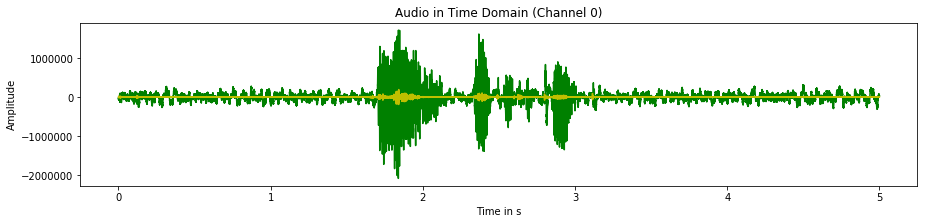

In [31]:
plt.figure(num=None, figsize=(15, 3))
plt.title('Audio in Time Domain (Channel {})'.format(0))
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
plt.plot(time_axis, frames[:,0], 'g-', label = "Input Audio")
plt.plot(time_axis, frames_out[:,0], 'y-', label="SW Filter")
plt.show()